# **ODIN Project** 

In [1]:
import boto3 
import pandas as pd 
import pymysql
import pymssql 
import os 
import json 
import warnings 
import numpy as np 
import squarify as sq 
from itertools import product
from datetime import datetime 
from sqlalchemy import create_engine
from collections import defaultdict
import logging 

from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn import metrics

import matplotlib.pyplot as plt 
import seaborn as sns 
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.colors import ListedColormap

from typing import List, Dict 

warnings.filterwarnings('ignore')
pd.options.display.max_rows = 70

## **Project Resources**

In [4]:
secrets = boto3.client('secretsmanager')
s3 = boto3.client('s3')
s3.download_file(Bucket=os.environ.get('TAX').split("/")[2], Key='/'.join(os.environ.get('TAX').split("/")[3:]), Filename="/tmp/fueltaxes.xlsx")

## **DB Auth** 

In [6]:
user1, passwd1, host1, db1, _ = list(json.loads(secrets.get_secret_value(SecretId=os.environ.get('MYSQL')).get('SecretString')).values())
con1: 'MYSQL' = pymysql.connect(user=user1, password=passwd1, db=db1, host=host1)
cursor1 = con1.cursor()

user2, passwd2, host2, db2 = list(json.loads(secrets.get_secret_value(SecretId=os.environ.get('MSSQL')).get('SecretString')).values())
con2: 'MSSQL' = pymssql.connect(user=user2, password=passwd2, database=db2, server=host2)
cursor2 = con2.cursor()


##  **Fuel Taxes**
Gasoline prices in the United States, a constant presence in our lives, are subject to various factors. Beyond the fundamental dynamics of supply and demand, the influence of taxation adds a complex layer to the composition of gasoline prices. This study embarks on a comprehensive exploration, delving into the multifaceted impact of state gasoline taxes on the cost of fuel. 

1. **State Gasoline Taxes**: State governments employ gasoline taxes to fund diverse projects, ranging from infrastructure endeavors to environmental conservation. The resultant disparity in tax rates shapes substantial price variations, affecting consumers and regional economies alike. Understanding the interplay between state budget priorities and gasoline taxes is vital for understanding the multifaceted nature of gasoline pricing. 
2. **Taxation as a Price Driver**: State governments have the power to impose gasoline taxes, both at the state and local levels. These taxes are calculated as a fixed amount per gallon or as a percentage of the retail price. As a result, the impact of taxation on gasoline prices is significant, often representing a substantial portion of the final cost consumers pay. The imposition of taxes contributes to the overall price structure and varies across states, leading to notable disparities in gasoline prices from one region to another. 
3. **Consumer Behavior and Economic Impact**: High gasoline taxes can alter consumer behavior, influencing travel patterns, vehicle purchases, and commuting choices. Regions with lower gasoline taxes may experience increased economic activity as consumers have more income, potentially leading to higher demand and pricing dynamics. On the other hand, areas with higher gasoline taxes might witness reduced consumption, impacting local economies. The interplay between consumer behavior, taxation, and pricing showcases the intricate balance taxation introduces to the gasoline market. 
4. **Environmental and Policy Consideration**: Some states leverage gasoline taxes as a policy tool to promote environmental sustainability. Higher gasoline taxes promote the adoption of fuel-efficient vehicles, public transportation, and cleaner energy alternatives. In this context, taxation influences prices and aligns with broader environmental and policy goals. The convergence of taxation and environmental considerations emphasizes the multifaceted nature of gasoline pricing.
   
Gasoline prices in the United States are a symphony of economic, regulatory, and societal factors. As a key player in this intricate composition, taxation introduces complex dynamics that ripple through the gasoline market. State gasoline taxes hold a multifaceted role beyond mere pricing, from funding critical infrastructure projects to shaping consumer behavior and advancing environmental objectives. A comprehensive comprehension of taxation's effects on gasoline prices is of utmost importance for individuals and policymakers, particularly as energy landscapes and policy priorities shift.

In [40]:
tax_df: 'DataFrame' = pd.read_excel("/tmp/fueltaxes.xlsx", sheet_name='January 2023')
tax_df = tax_df.iloc[7:63].drop(['Unnamed: 5', 'Unnamed: 10'], axis=1).rename(dict(map(lambda item: (item[0], item[1].strip()), tax_df.iloc[5].dropna().to_dict().items())), axis=1)
tax_df.index = np.arange(1, tax_df.shape[0] + 1)
tax_df = tax_df.replace({np.nan: 0.0})
tax_df.columns = [tax_df.columns[0].strip().lower()] +\
                 [ ('gasoline_%s' % (col)).strip().replace(' ', '_').lower() for col in tax_df.columns.tolist()[1:5] ] +\
                 [ ('diesel_%s' % (col)).strip().replace(' ', '_').lower() for col in tax_df.columns.tolist()[5:-1] ] +\
                 [tax_df.columns[-1].lower()]

states, gasoline_taxes = zip(*tax_df[tax_df.columns.tolist()[:5]].sort_values(by='gasoline_state_tax', ascending=True).set_index(tax_df.columns[0])['gasoline_state_tax'].to_dict().items())
all_states, state_fed_tax = zip(*tax_df[tax_df.columns.tolist()[:5]].sort_values(by='gasoline_state_&_federal', ascending=True).set_index(tax_df.columns[0])['gasoline_state_&_federal'].to_dict().items())

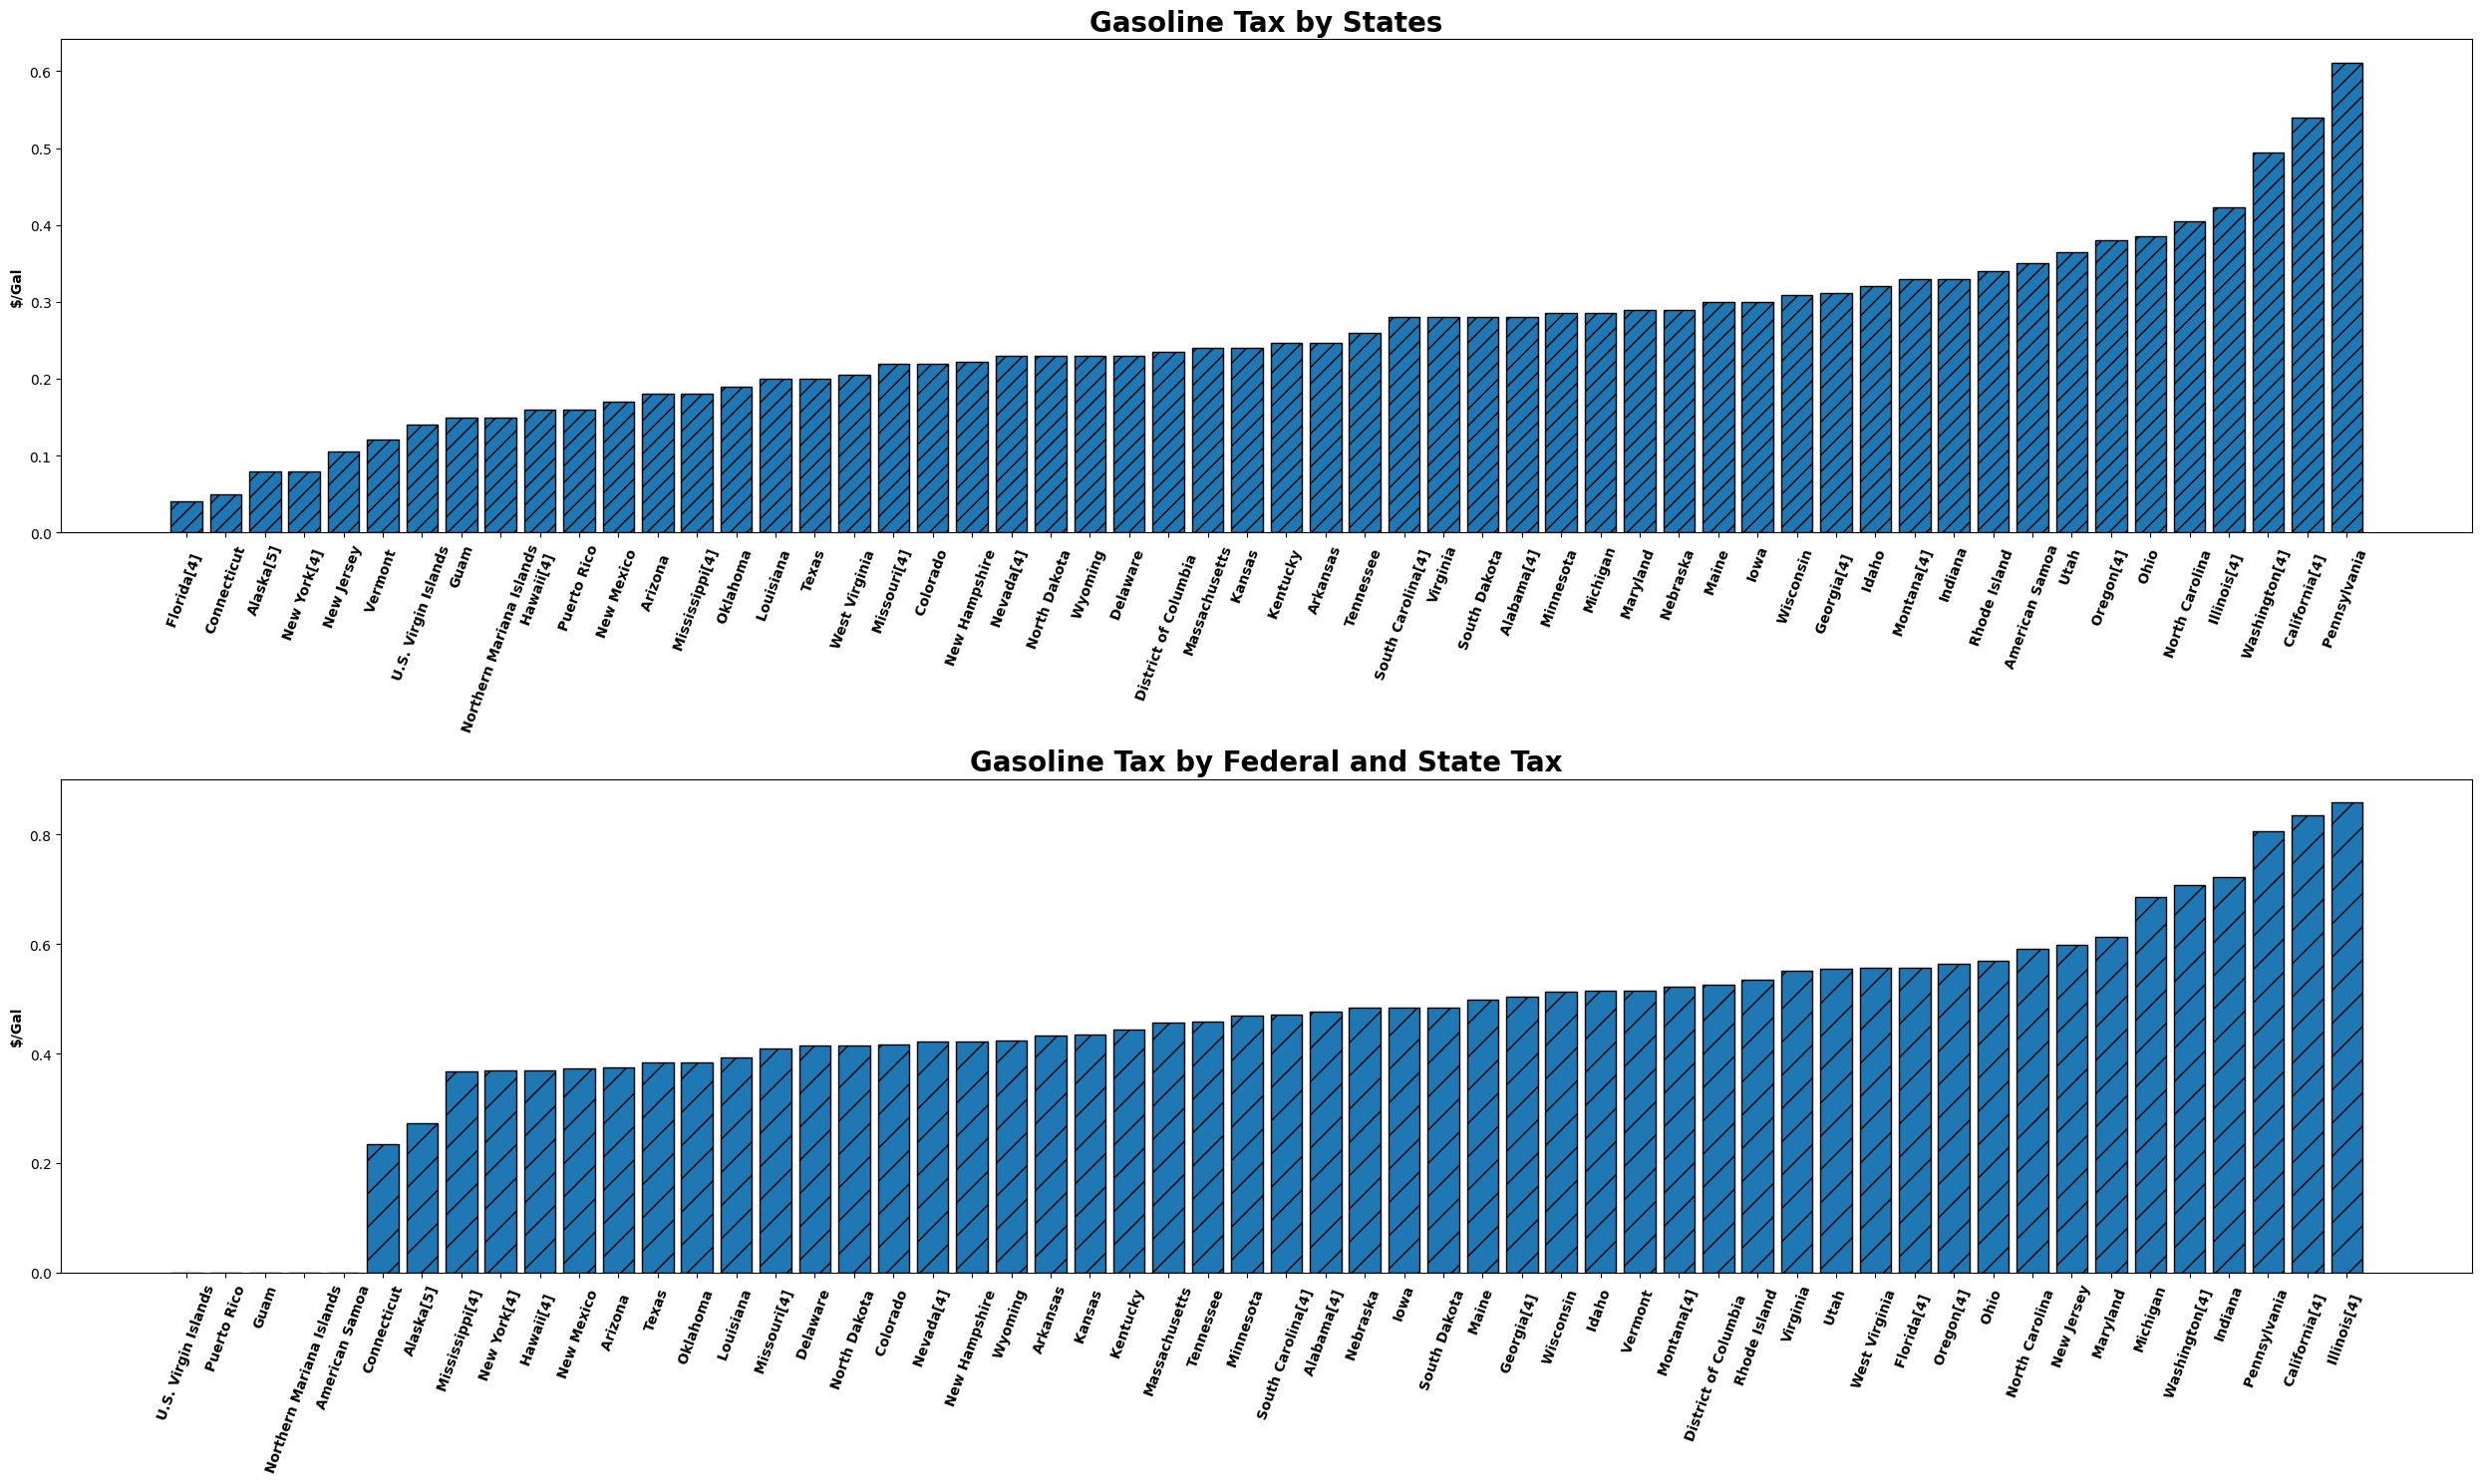

In [62]:
fig = plt.figure(figsize=(25,15) )
ax = fig.add_subplot(2,1,1)

# States 
ax.bar(x=list(states), height=list(gasoline_taxes), hatch="//", edgecolor='k')
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, fontweight='bold')
ax.set_title("Gasoline Tax by States", fontweight='bold', fontsize=20)
ax.set_ylabel("$/Gal", fontweight='bold')
plt.tight_layout() 

# Fed
ax = fig.add_subplot(2,1,2)
ax.bar(x=list(all_states), height=list(state_fed_tax), hatch="/", edgecolor='k') # color='red')
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, fontweight='bold')
ax.set_title("Gasoline Tax by Federal and State Tax", fontweight='bold', fontsize=20)
ax.set_ylabel("$/Gal", fontweight='bold')
plt.tight_layout() 

## **Gasoline Mixtures**
Gasoline prices, a constant presence in our daily routines, result from an intricate interplay of factors. Among these, the seasonal variation in gasoline mixture stands out as a critical yet often overlooked contributor to the cost at the pump. This study aims to understand the complexities of the gasoline mixture adjustments between summer and winter and the federal regulations that govern this process. 
1. **Seasonal Gasoline Mixture Adjustments**: The transition between summer and winter in the United States brings about more than just a change in weather. It prompts a fundamental shift in gasoline composition to cater to specific environmental and performance demands. During the summer months, gasoline is formulated with a different blend to mitigate the impact of higher temperatures on air quality. Additives like butane and ethanol are incorporated to enhance combustion efficiency and minimize emissions. On the other hand, winter gasoline is designed to ensure reliable engine performance in colder temperatures. With higher volatility, winter gasoline facilitates easier cold starts, preventing stalling and ensuring smooth engine operation. The blending process involves modifying the ratio of hydrocarbons, additives, and ethanol, resulting in a distinct mixture tailored to the unique challenges of winter weather. 
2. **Butane Mixture**: Butane is an inexpensive additive with high RVP. Adding butane, a cost-effective hydrocarbon, to gasoline is a double-edged sword. 
Butane's high RVP is advantageous for cold starts and improved combustion during colder months. 
Its volatile nature increases evaporation, potentially raising smog levels in warmer seasons. The utilization of butane in gasoline blends represents a delicate balance between cost-effectiveness and environmental impact, further influencing pricing dynamics. 
3. **Federal Regulations and Reid Vapor Pressure (RVP)**: The complexity of seasonal gasoline mixtures is guided by federal regulations, specifically regarding RVP (Reid Vapor Pressure). RVP measures gasoline's volatility, influencing its evaporation rate and potential contribution to air pollution. The EPA (Environmental Protection Agency) enforces stringent regulations on gasoline RVP levels to mitigate smog formation during warmer months. Federal law restricts the sale of gasoline with an RVP exceeding 9.0 psi (pounds per square inch) from June 1 through September 15, a period characterized by higher temperatures and increased potential for smog formulation. Gasoline retailers must ensure compliance with these regulations, offering summer-blend gasoline with reduced RVP during this period. The transition to summer-blend gasoline involves meticulous adjustments by refineries to maintain compliance with federal guidelines. 

The significant interaction between seasonal gasoline mixture adjustments and federal regulations exemplifies the intricate nature of gasoline pricing. The shift from summer to winter blends and vice versa goes beyond mere adaptation to weather conditions; it reflects a delicate balance between environmental concerns, engine performance, and regulatory compliance. Federal laws governing gasoline RVP levels during specific periods underscore the commitment to air quality preservation. 
Understanding these complexities is paramount as consumers and policymakers navigate the landscape of gasoline prices. Seasonal gasoline mixture adjustments, guided by federal regulations, are a testament to the multifaceted approach required to ensure efficient and environmentally conscious fuel consumption. In a world shaped by evolving energy standards and environmental consciousness, unraveling the intricate tapestry of gasoline mixture dynamics and federal oversight is a compass for a more sustainable energy future. 

In [10]:
%%time 
tbl_one: str = os.environ.get('tbl_one') 
# 1.7e6 
query: str = f"""

    SELECT
        lg.index,
        lg.gas_station,
        lg.country,
        lg.city,
        lg.address,
        lg.zip_code,
        lg.state,
        lg.regular_gas,
        lg.midgrade_gas,
        lg.premium_gas,
        lg.price_unit,
        lg.star_rating,
        lg.latitude,
        lg.longitude,
        lg.timestamp,
        CASE 
            WHEN lg.timestamp BETWEEN STR_TO_DATE(CONCAT(YEAR(lg.timestamp),'-', 6, '-', DAY(lg.timestamp) ), '%Y-%m-%d' ) AND STR_TO_DATE(CONCAT(YEAR(lg.timestamp),'-', 9, '-', DAY(lg.timestamp) ), '%Y-%m-%d' ) THEN 'yes'
            ELSE 'no'
        END AS rvp,
        CASE 
            WHEN MONTHNAME(lg.timestamp) IN ('March', 'April', 'May') THEN 'Spring'
            WHEN MONTHNAME(lg.timestamp) IN ('June', 'July', 'August') THEN 'Summer'
            WHEN MONTHNAME(lg.timestamp) IN ('September', 'October', 'November') THEN 'Fall'
            ELSE 'Winter'
        END AS `season`, 
        lg.price,
        lg.review,
        lg.review_date,
        lg.sentiment_score
        
    FROM {tbl_one} lg 
""" 

gasprices_df: 'DataFrame' = pd.read_sql(query,con=con1)
gasprices_df['transc_date'] = pd.to_datetime(gasprices_df['timestamp']).apply(lambda row: row.strftime('%Y-%m-%d'))

gasprices_df.head()

CPU times: user 15.9 s, sys: 896 ms, total: 16.8 s
Wall time: 16.9 s


,index,gas_station,country,city,address,zip_code,state,regular_gas,midgrade_gas,premium_gas,...,latitude,longitude,timestamp,rvp,season,price,review,review_date,sentiment_score,transc_date
0,0,1st Place Food Mart,US,Tillmans Corner,7000 Three Notch-Kroner Rd,36619,AL,1,1,1,...,30.589132,-88.205224,2023-05-21T12:10:31.001Z,no,Spring,2.82,love the cheaper gas.,2022-05-02T18:39:36.45Z,1.00000,2023-05-21
1,1,Zippy Mart,US,Tillmans Corner,5936 Three Notch Rd,36619,AL,1,1,1,...,30.589263,-88.179333,2023-05-22T00:19:42.007Z,no,Spring,2.82,GOOD SERVICE,2017-01-23T09:40:24.88Z,0.57020,2023-05-22
2,2,AAFES,US,Fort McClellan,1167 Fremont Rd,36205,AL,1,1,1,...,33.731789,-85.791281,2023-05-21T19:29:16.272Z,no,Spring,2.82,Military and family members only. They earned ...,2019-06-27T20:13:50.033Z,-0.19800,2023-05-21
3,3,Sam's Club,US,Auburn,2335 Bent Creek Rd,36830,AL,1,0,1,...,32.608063,-85.428061,2023-05-22T02:21:02.515Z,no,Spring,2.84,Generally best price in town.,2022-11-02T19:20:19.87Z,0.81845,2023-05-22
4,4,Sunoco,US,Leeds,7501 Parkway Dr,35094,AL,1,0,1,...,33.544691,-86.554397,2023-05-21T13:38:20.812Z,no,Spring,2.82,great service and amazing Race Fuels,2020-06-18T14:01:04.797Z,0.76800,2023-05-21


## **Remove Duplicates Entries from DB1**

In [50]:
backup_df: 'DataFrame' = gasprices_df.drop_duplicates(['gas_station', 'timestamp', 'review', 'review_date', 'latitude' ,'longitude']) 
backup_df.to_csv(f"{_}/dataset/backup_livegasprices_tbl_{datetime.utcnow().isoformat()}.csv")
cols: List[str] = gasprices_df.iloc[0].index.tolist()
url: str = "mysql+pymysql://%s:%s@%s:3306/%s"  % (user1,passwd1,host1,db1)

cursor1.execute(f"DROP TABLE {tbl_one}")
con1.commit() 

engine: 'MYSQL' = create_engine(url)
backup_df.to_sql(tbl_one, con=engine, if_exists='replace')

## **Explore Historical Gasoline Prices by States**

### **Boxplot Gasoline Prices by States**

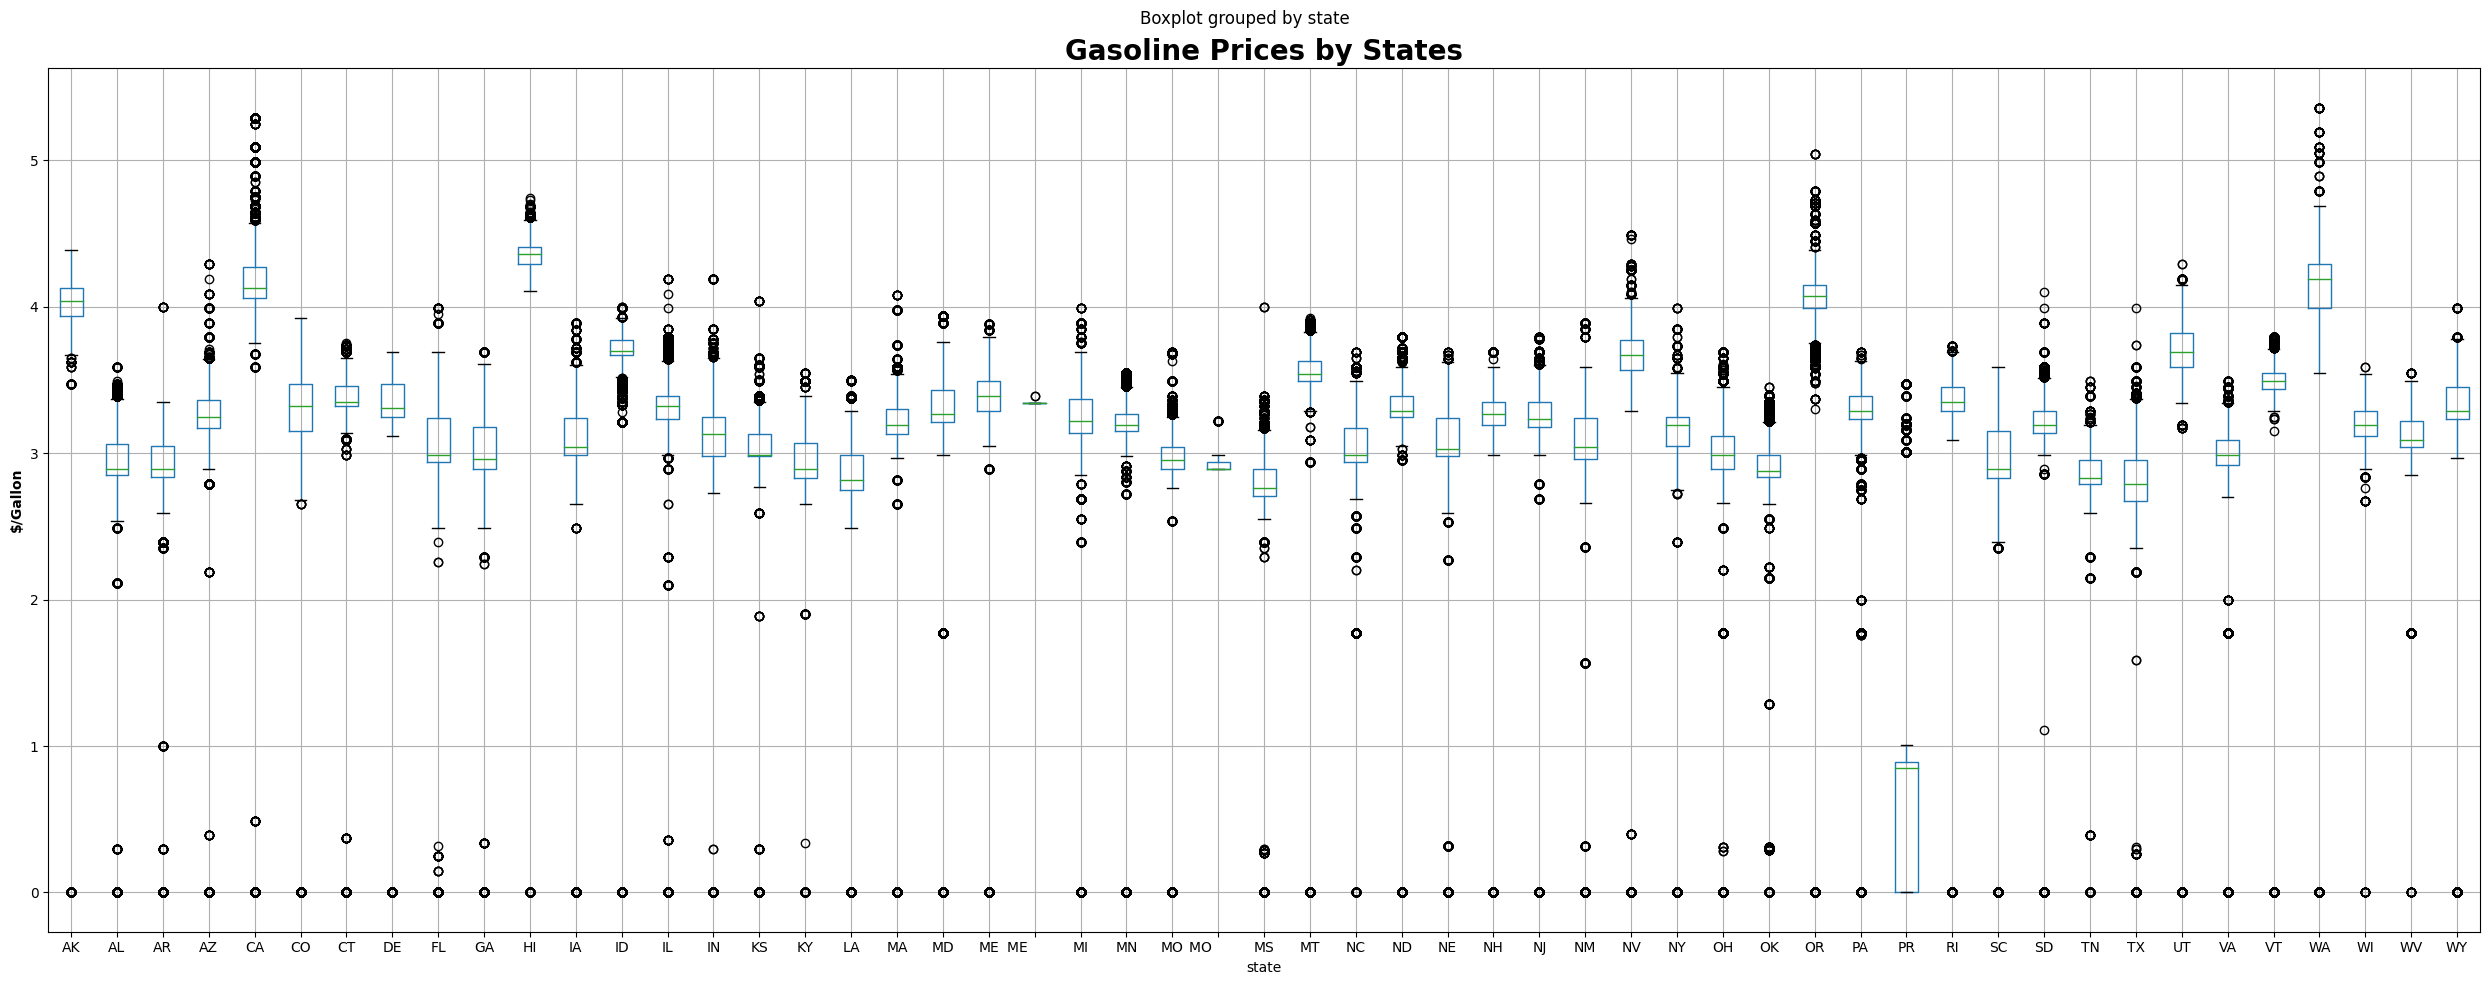

In [7]:
fig = plt.figure(figsize=(25,10)) 
ax = fig.add_subplot() 
gasprices_df.boxplot(by='state', column='price',ax=ax)
ax.set_title("Gasoline Prices by States", fontweight='bold', fontsize=20)
ax.set_ylabel("$/Gallon", fontweight='bold')

plt.tight_layout() 

### **Histogram Gasoline Prices by States**

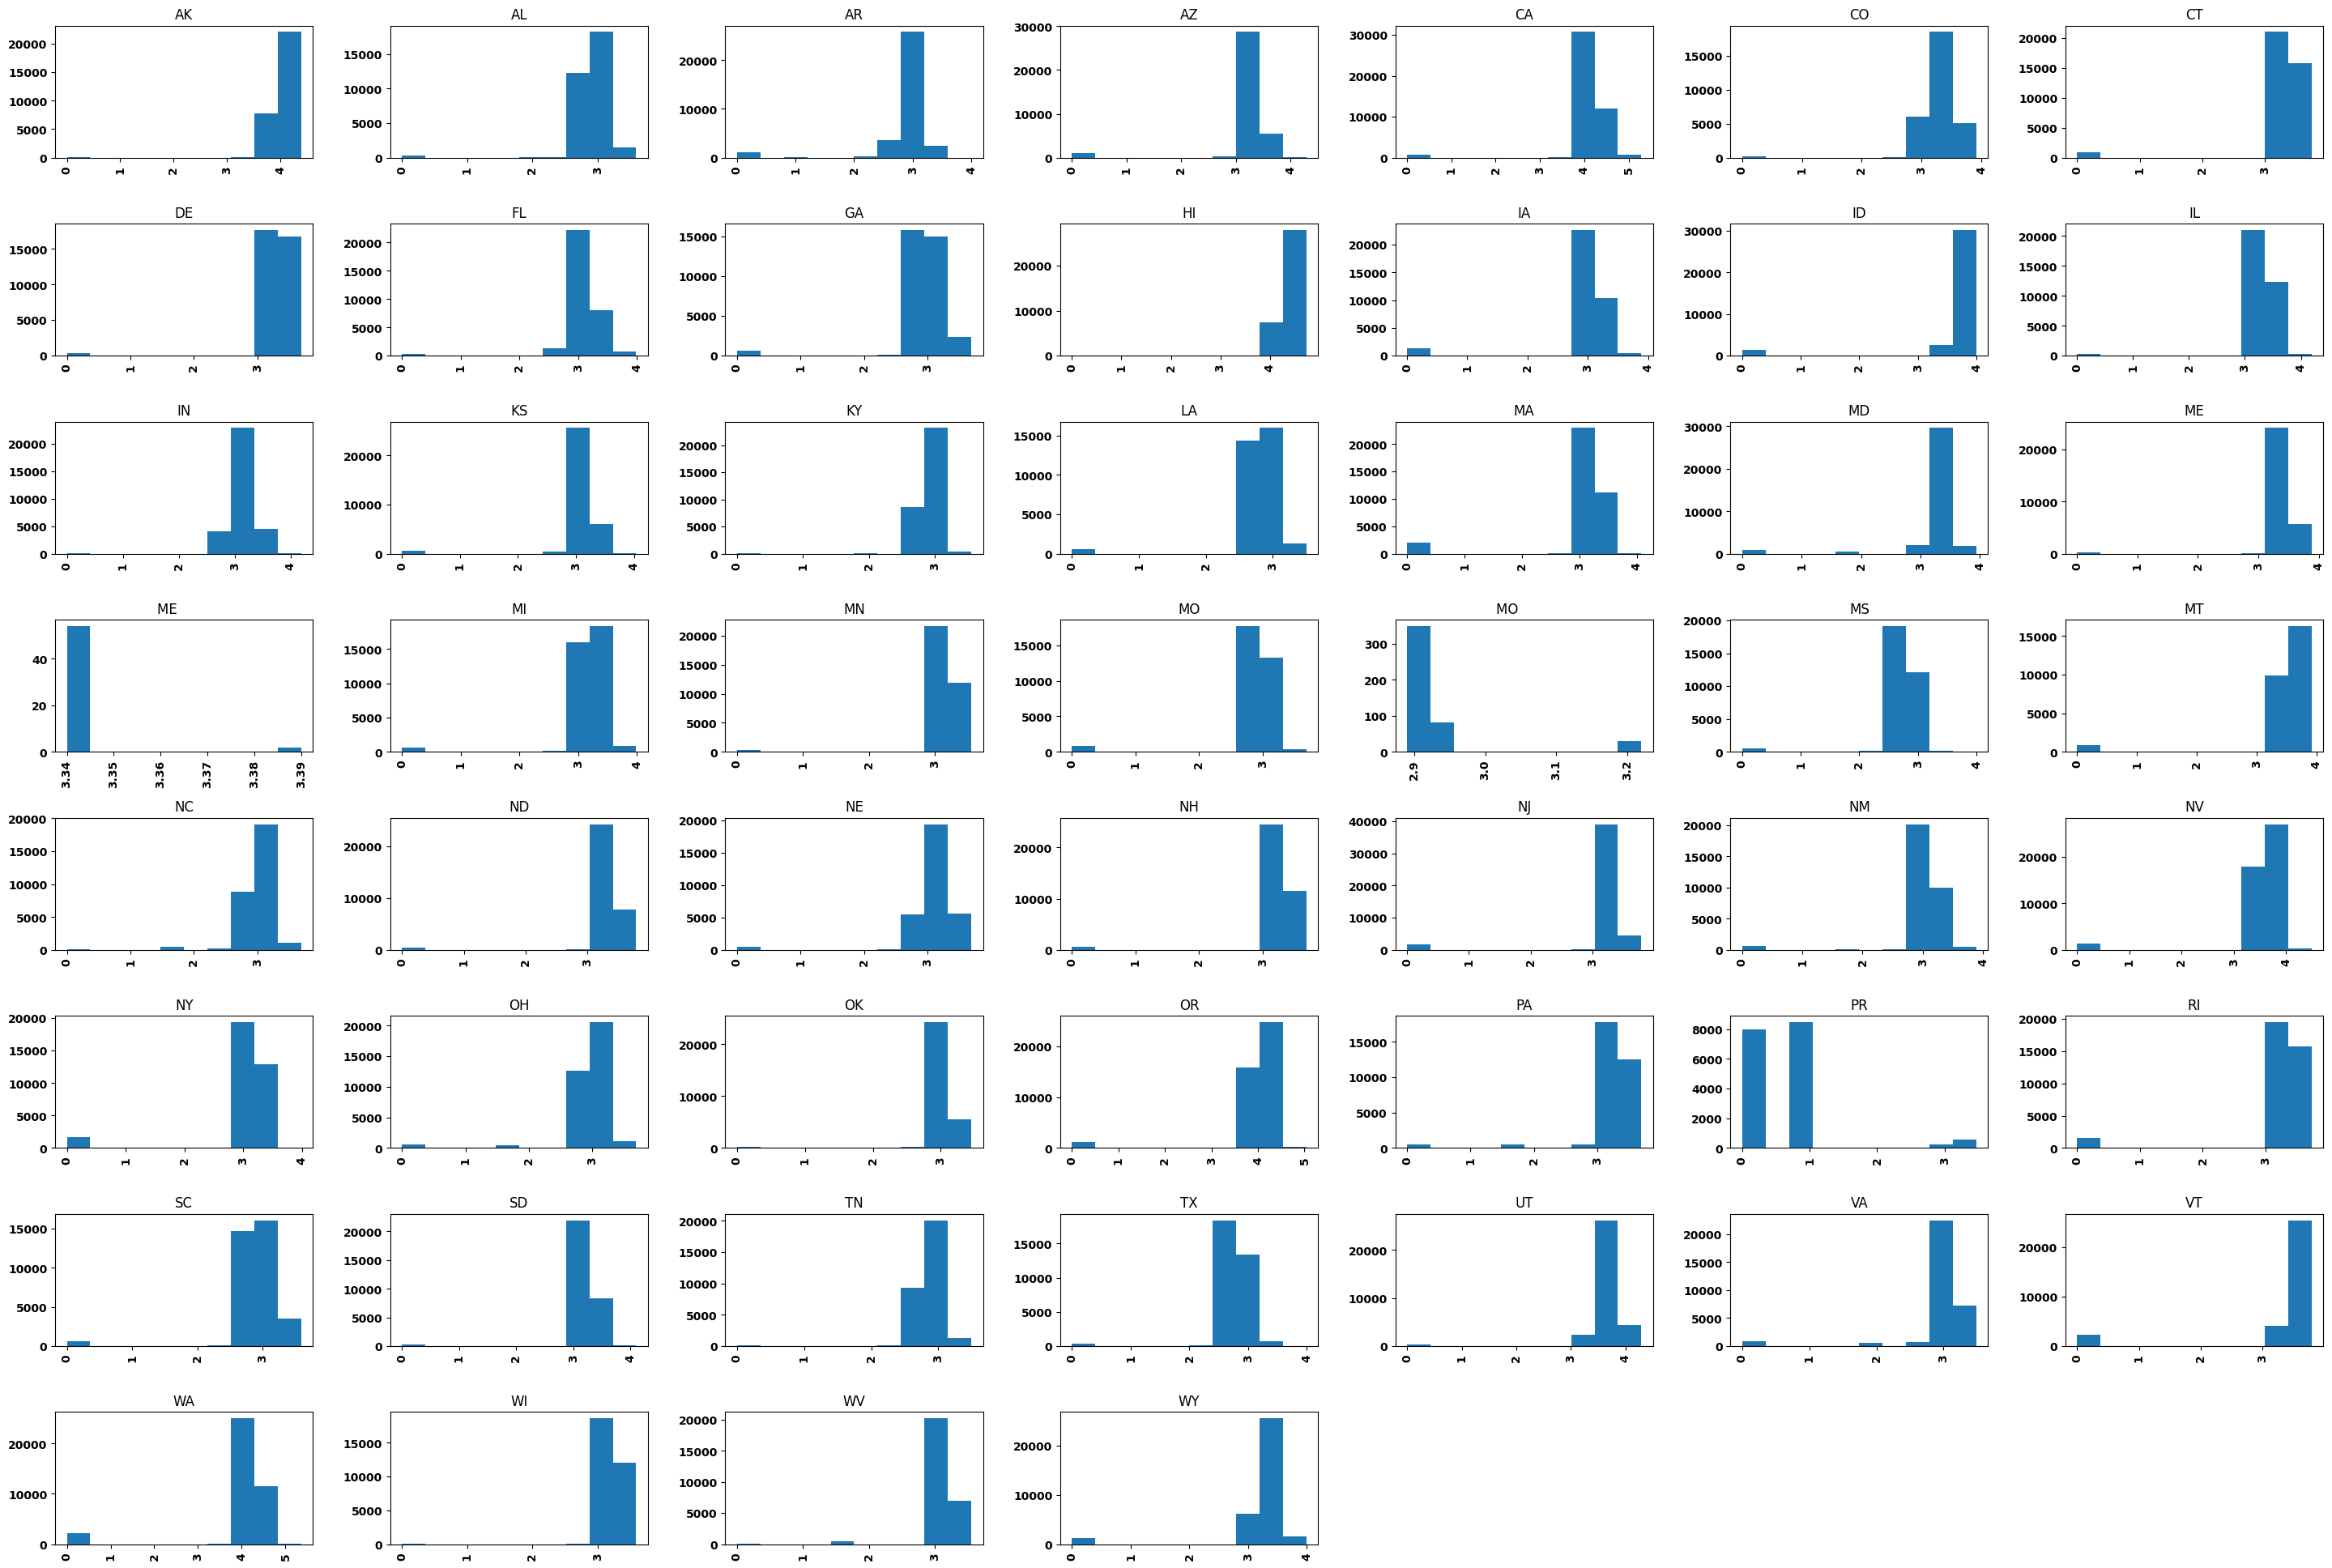

In [172]:
plt.rcParams['figure.figsize'] = (35,25)
plt.rcParams['font.weight'] = 'bold'
axs = gasprices_df.hist(by='state', column='price')
states: List[str] = gasprices_df['state'].dropna().astype(str).apply(lambda row: row.strip()).unique().tolist()

## **Average Gasoline Prices and Number of Visitors** 

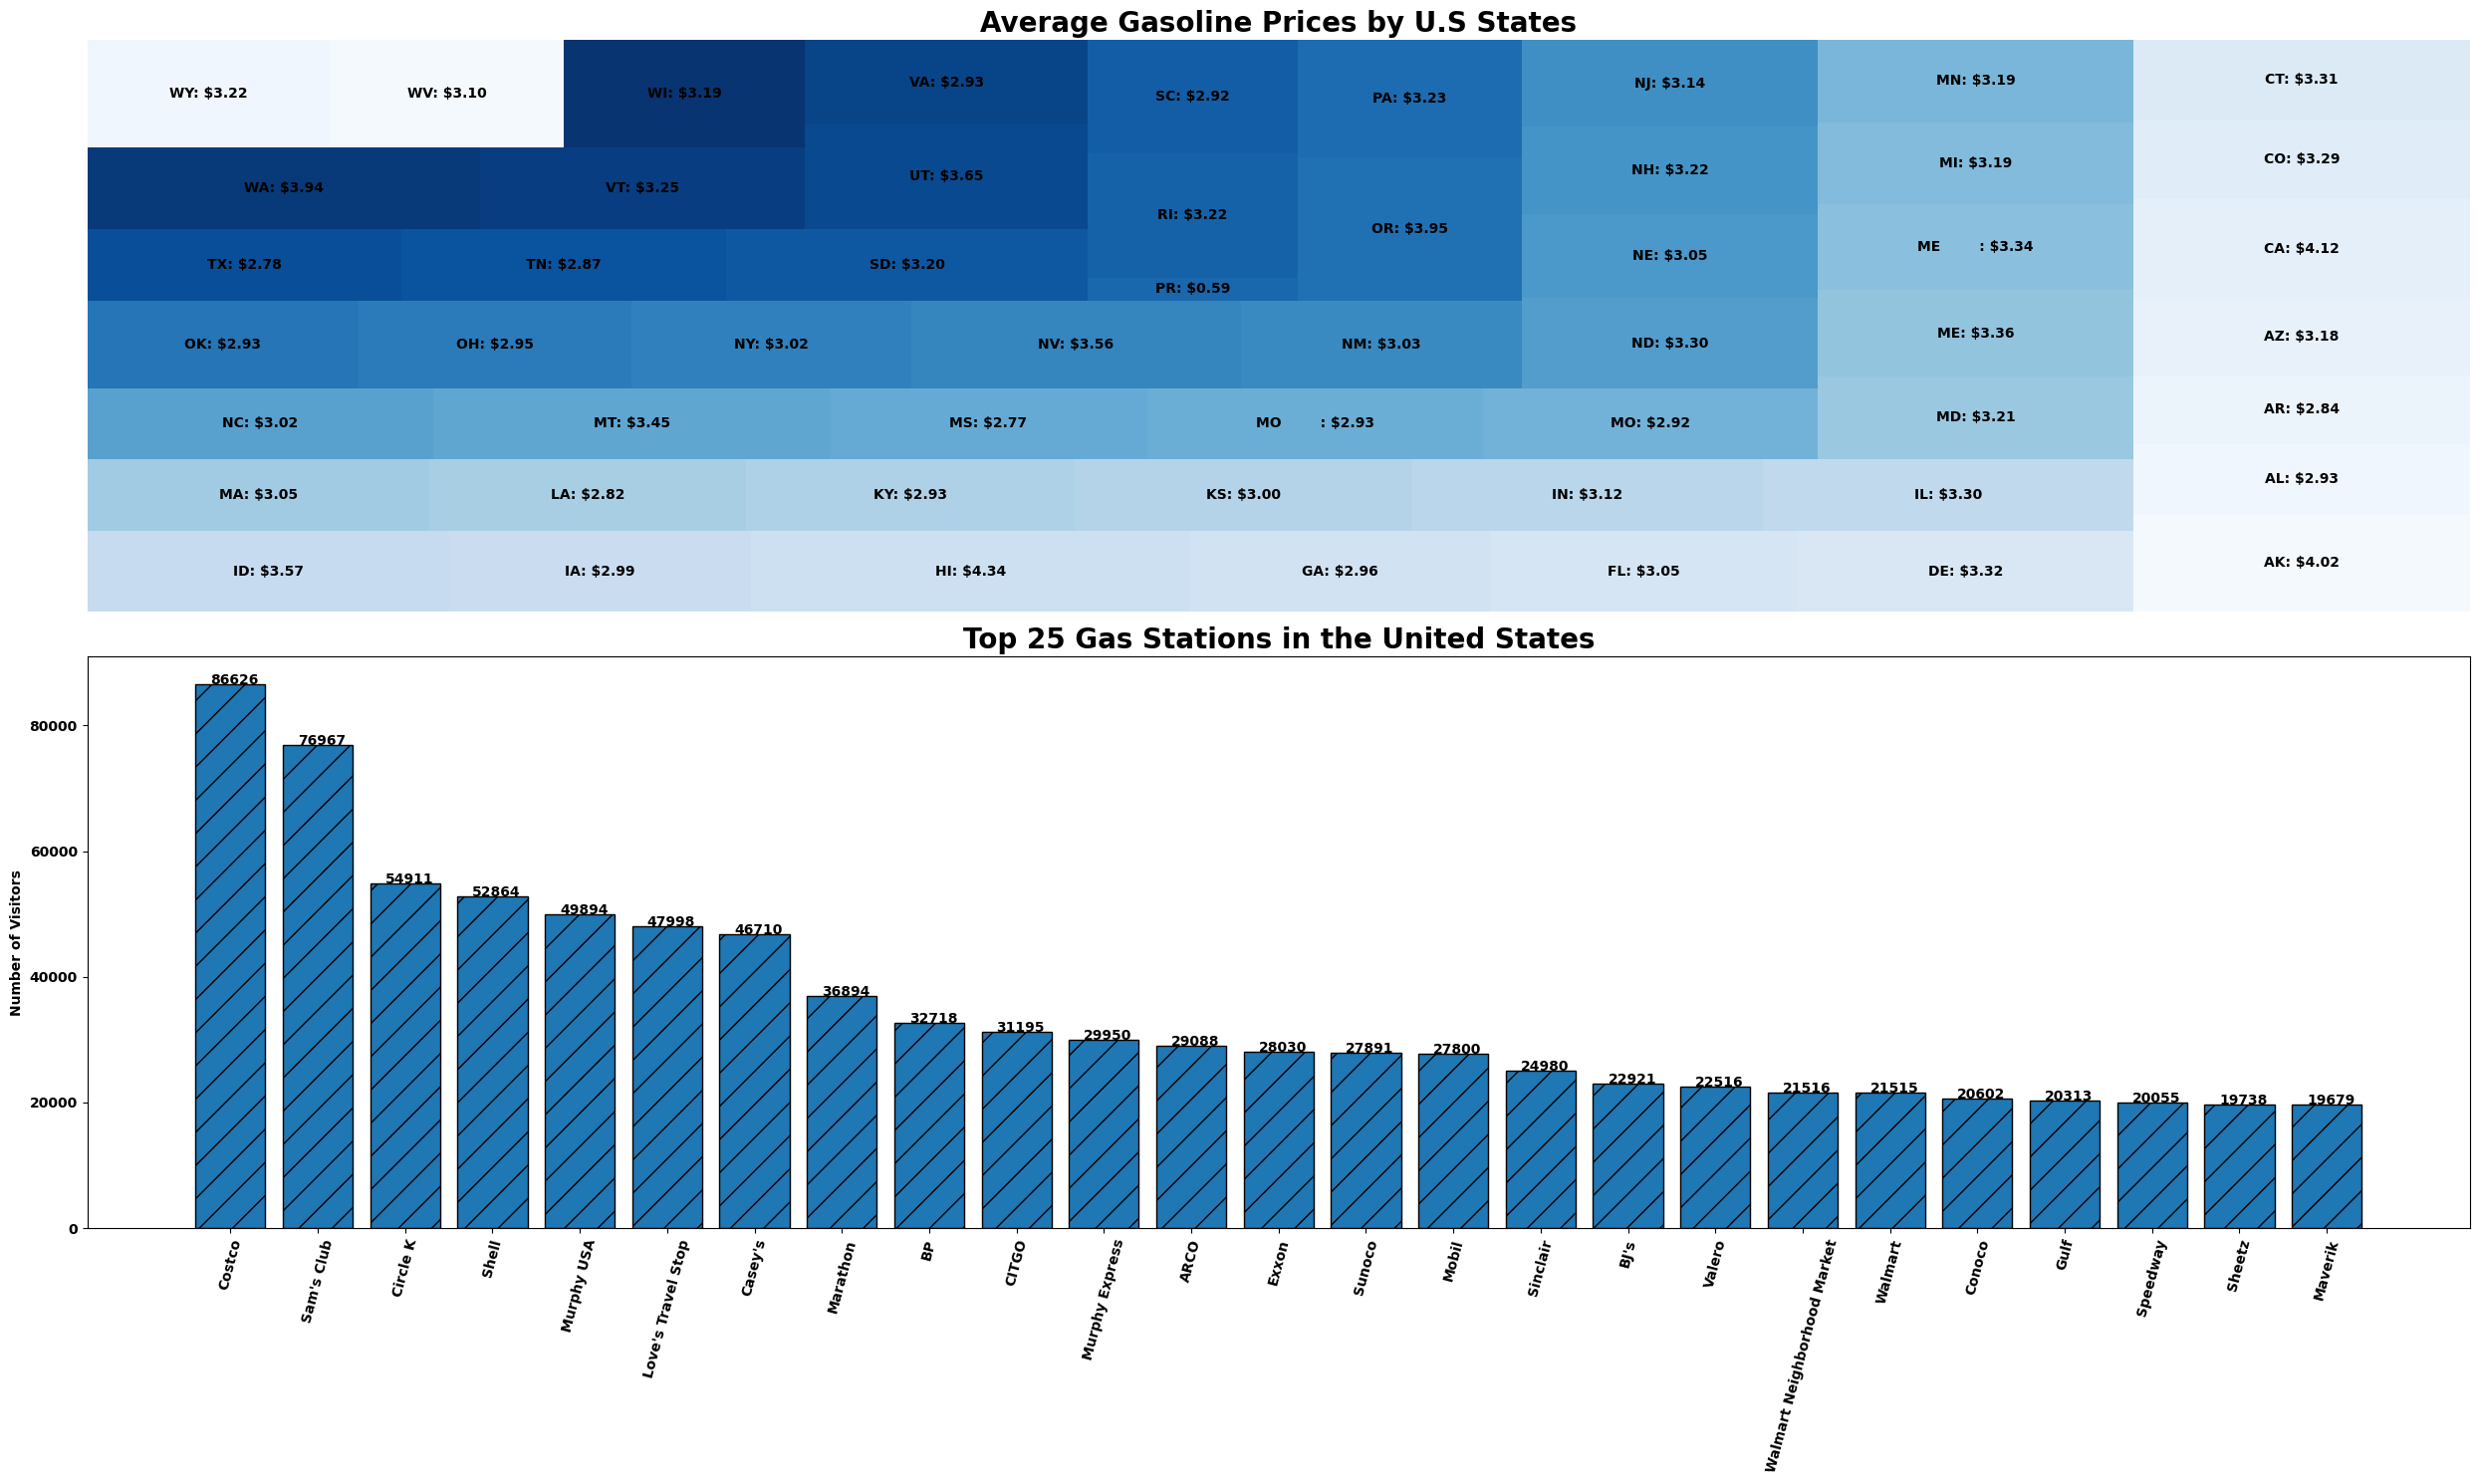

In [189]:
states, avg_price = zip(*gasprices_df.groupby('state')['price'].agg('mean').to_dict().items())
fig = plt.figure(figsize=(25,15))
ax = fig.add_subplot(2,1,1) 

sq.plot(sizes=list(avg_price), 
        label=[ f"{item[0]}: ${item[1]:.2f}" for item in zip(states, avg_price) ],
        ax=ax,
        color=sns.color_palette(palette='Blues', n_colors=51)
       )

ax.axis('off')
ax.invert_xaxis()
ax.set_title("Average Gasoline Prices by U.S States", fontweight='bold', fontsize=20)

gas_stations, n_transcs = zip(*gasprices_df['gas_station'].value_counts().head(25).items())
ax = fig.add_subplot(2,1,2)
ax.bar(x=list(gas_stations), height=list(n_transcs),edgecolor='k', hatch='/')
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold', rotation=75)
ax.set_title("Top 25 Gas Stations in the United States", fontweight='bold', fontsize=20)
for index,visitor in enumerate(n_transcs): 
    ax.annotate(visitor, xy=(index - 0.23,visitor), fontweight='bold')
ax.set_ylabel('Number of Visitors', fontweight='bold' )


plt.tight_layout() 

## **Average Gasoline Prices by States and Gas Stations**

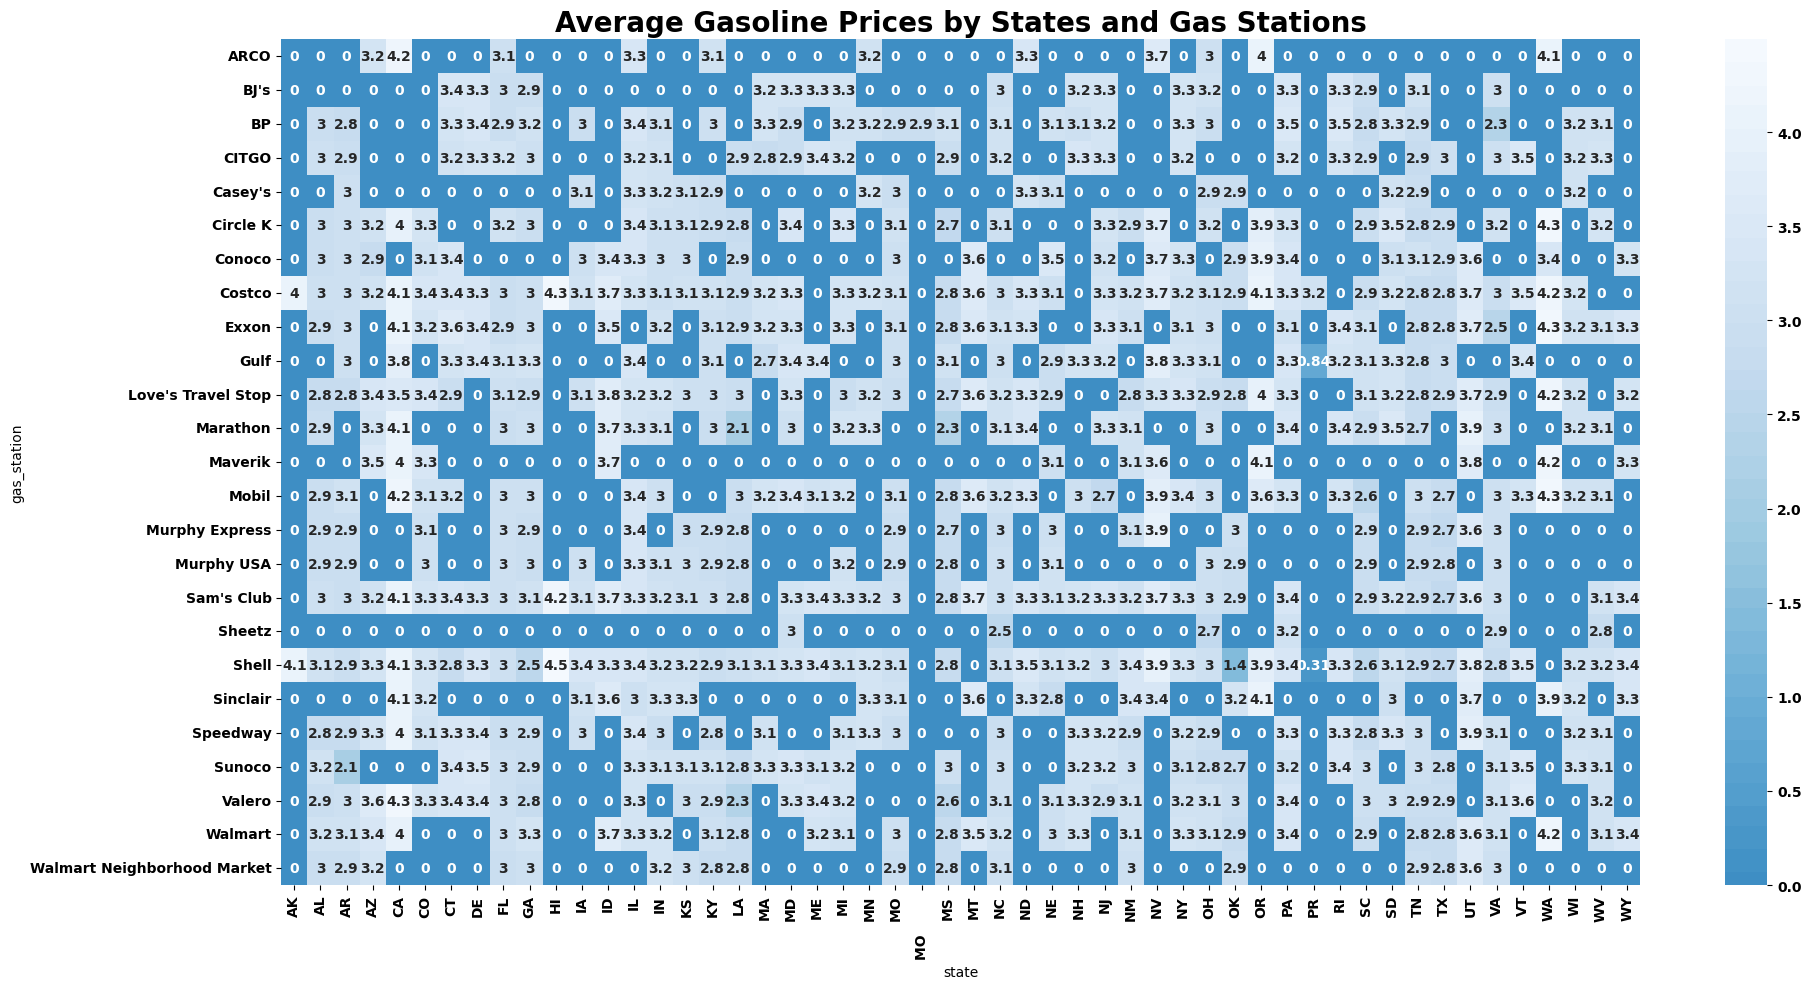

In [192]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot()
sns.heatmap( pd.pivot_table(data=gasprices_df[gasprices_df['gas_station'].isin(gas_stations)], columns=['state'], index=['gas_station'], values='price', aggfunc='mean').replace({np.nan:0.0}), 
            annot=True, 
            ax=ax, 
            center=True,
            cmap=ListedColormap(sns.color_palette(palette='Blues_r', n_colors=60) ))
ax.set_title("Average Gasoline Prices by States and Gas Stations", fontweight='bold', fontsize=20)

plt.tight_layout() 

## **Trends: Total Average Gasoline Price in the U.S**

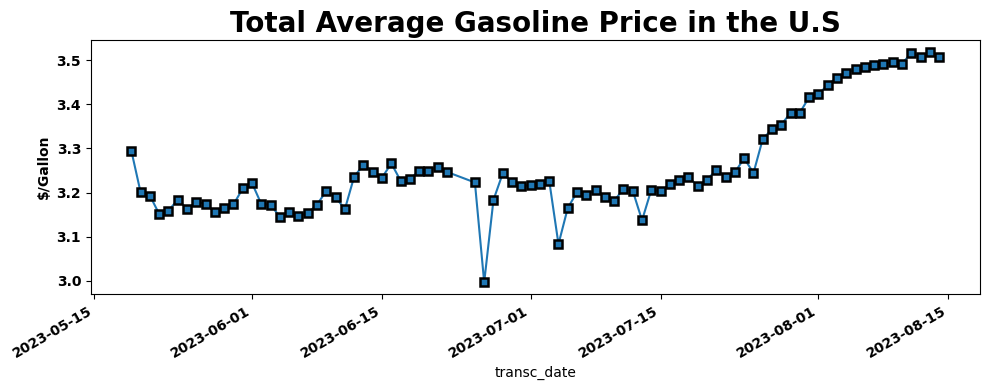

In [212]:
avg_gasoline_prices: 'Series' = gasprices_df.groupby('transc_date')['price'].mean()
avg_gasoline_prices.index = pd.to_datetime(avg_gasoline_prices.index )

fig = plt.figure(figsize=(10,4)) 
ax = fig.add_subplot()
avg_gasoline_prices.plot( marker='s', mec='black', mew=1.8)  # Average Gasoline Prices in the U.S
ax.set_title("Total Average Gasoline Price in the U.S", fontweight='bold', fontsize=20)
ax.set_ylabel("$/Gallon", fontweight='bold')

plt.tight_layout() 

# **Modeling Gasoline Prices in Washington State using SARIMAX**
- Exo variables:
1. Season (Not enough data)
2. RVP
3. Gasoline Types
 
**Note**: 
1. source_one was collected from May **19,2023**, until today.
2. source_two was collected from August 04, 2023, until today.

In [23]:
query: str = f"""
                /*
                    Gasoline price in State of Washington 
                */
                SELECT 
                    g.gas_station_name, 
                    g.pay_status, 
                    g.posted_time,
                    g.address, 
                    g.zip_code,
                    g.payment_type,
                    g.price
                
                FROM {mssql_func_one}('WA') g ORDER BY CAST( posted_time AS DATETIME ) ASC
                
            """


wa_prices_source2: 'DATAFRAME' = pd.read_sql(query, con=con2) # Source 2 
wa_prices_source2.head()

,gas_station_name,pay_status,posted_time,address,zip_code,payment_type,price
0,Swinomish Markets at the Casio,1,2023-08-04 18:23:19.927,12939 Casino Dr,98221-8351,cash,4.15
1,Swinomish Markets at the Casio,1,2023-08-04 18:23:19.927,12939 Casino Dr,98221-8351,cash,4.15
2,Hwy 97 Truck Plaza,1,2023-08-05 01:41:02.793,61313 Hwy 97,98948,credit_card,4.15
3,Hwy 97 Truck Plaza,1,2023-08-05 01:41:02.793,61313 Hwy 97,98948,credit_card,4.15
4,Meridian Liquor Store,1,2023-08-05 12:14:32.347,4209 Meridian St,98226-5512,cash,4.39


In [29]:
wa_prices_source2.groupby(['gas_station_name', 'payment_type'])['price'].mean().unstack('payment_type').replace({np.nan: 0.0}).applymap(lambda row: round(row, 2) ).replace({0.0: "N/A"})

payment_type,cash,credit_card
gas_station_name,,
76,4.3,N/A
ARCO,4.33,N/A
Angel of the Winds Fuel,N/A,4.45
Costco,N/A,4.3
Harolds Market,N/A,4.1
Hwy 97 Truck Plaza,N/A,4.3
JK Gas & Groceries,4.39,N/A
Little Mountain Grocery,4.4,N/A
Maverik,N/A,4.37


In [11]:
plt.style.use('ggplot')
gasprices_df['transc_date'] = pd.to_datetime(gasprices_df['transc_date'])
gasprices_df['rvp_yes'] = pd.get_dummies( gasprices_df['rvp'], prefix='rvp' ).replace({True: 1, False: 0})['rvp_yes']
gasprices_df['timestamp'] = pd.to_datetime(gasprices_df['timestamp'])

wa_prices_df: 'DataFrame' = gasprices_df.query("state == 'WA' ")
wa_prices_df['month_name'] = pd.to_datetime(wa_prices_df['timestamp']).apply(lambda row: row.month_name())
sort_months: List[str] = pd.Series(pd.date_range(start='05-01-2023' , end='09-01-2023', freq='M')).apply(lambda row: row.month_name()).tolist() 
gasprice_by_city: 'DataFrame' = pd.pivot_table(data=wa_prices_df, index=['month_name'], columns=['city'], aggfunc='mean', values='price').replace({np.nan: 0.0}).transpose()[sort_months]

In [99]:
pd.DataFrame( gasprices_df.query("state == 'WA' ").groupby('season')['price'].mean().replace({0.0: np.nan}).dropna()).rename({'price': 'Gasoline Price in WA'}, axis=1)

,Gasoline Price in WA
season,
Spring,3.961230
Summer,4.172369


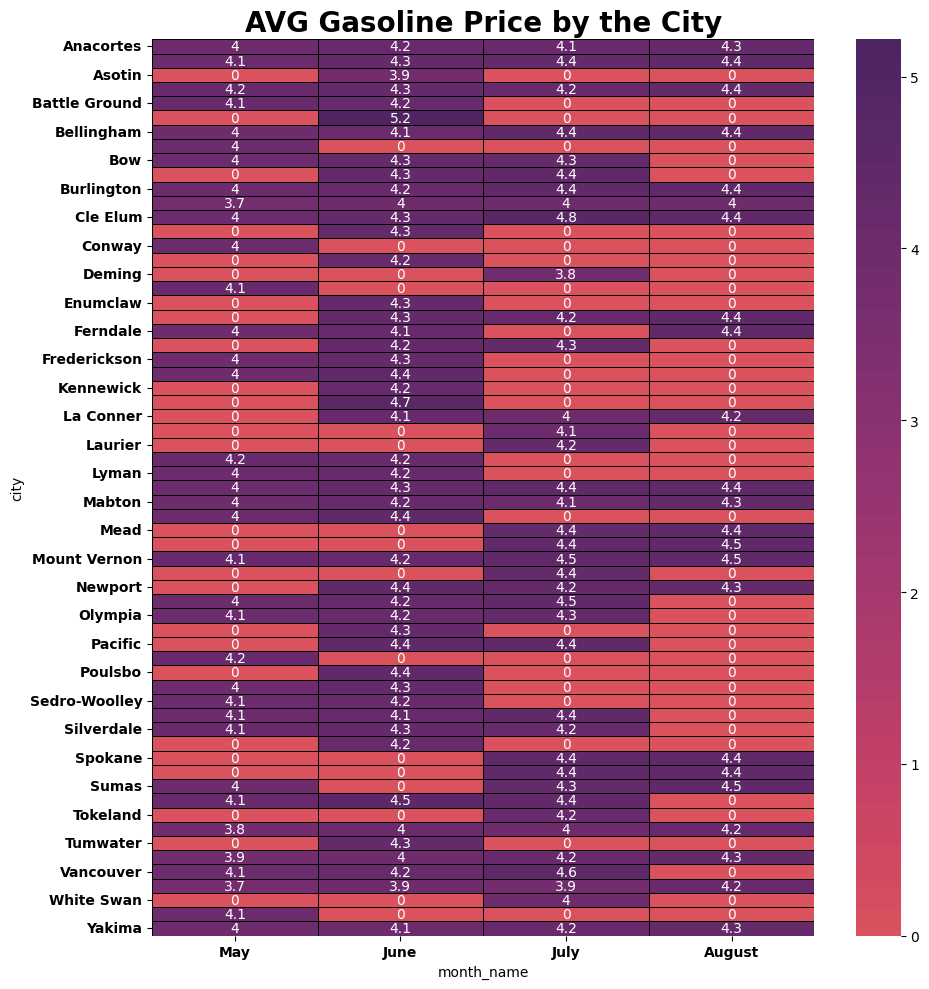

In [107]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
sns.heatmap(gasprice_by_city, annot=True, center=True ,ax=ax, cmap=ListedColormap(sns.color_palette(palette='flare', n_colors=70)), linewidths=0.7, linecolor='black')

ax.set_title("AVG Gasoline Price by the City", fontweight='bold', fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')

plt.tight_layout()

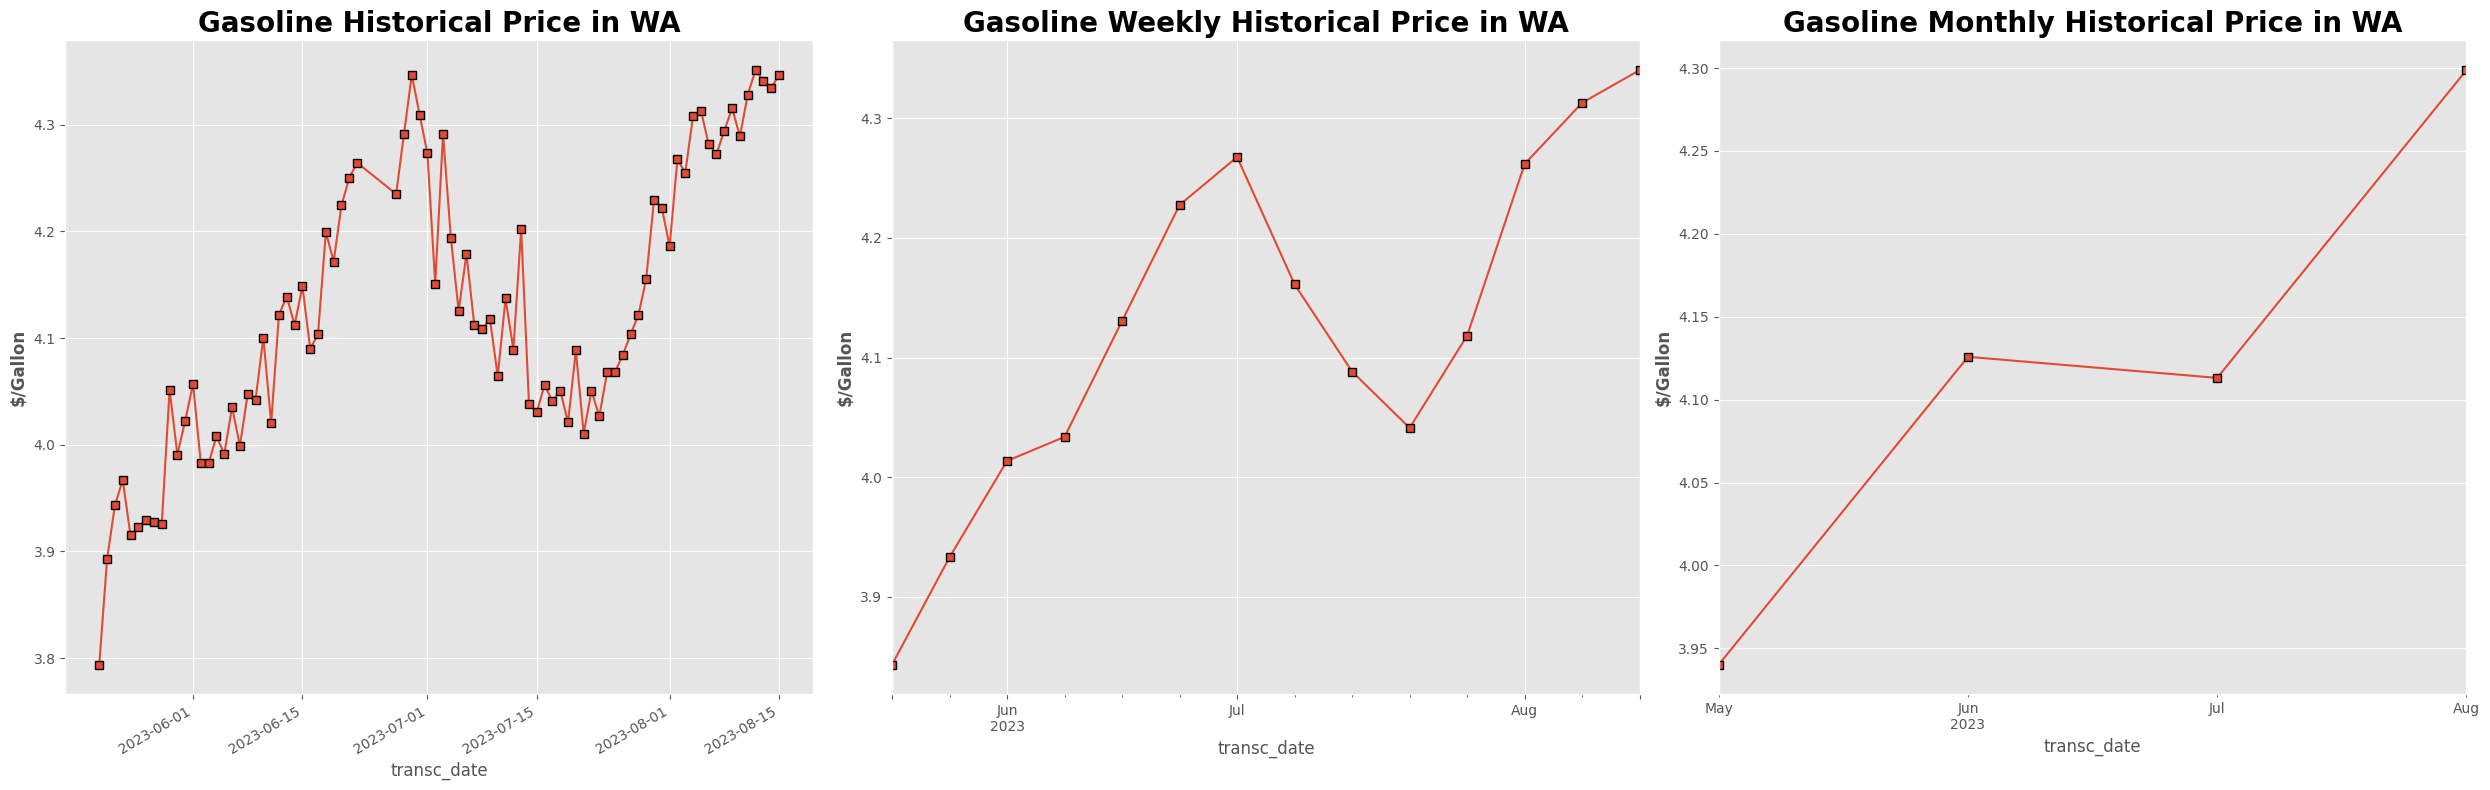

In [113]:
fig = plt.figure(figsize=(25,8)) 
ax = fig.add_subplot(1,3,1) 
gasprices_df.query("state == 'WA' ").groupby('transc_date')['price'].mean().plot(ax=ax, marker='s', mec='black')
ax.set_title("Gasoline Historical Price in WA", fontweight='bold', fontsize=20)
ax.set_ylabel("$/Gallon", fontweight='bold')

ax = fig.add_subplot(1,3,2) 
gasprices_df.query("state == 'WA' ").groupby('transc_date')['price'].mean().resample("W").mean().interpolate().plot(ax=ax, marker='s', mec='black')
ax.set_title("Gasoline Weekly Historical Price in WA", fontweight='bold', fontsize=20)
ax.set_ylabel("$/Gallon", fontweight='bold')

ax = fig.add_subplot(1,3,3) 
gasprices_df.query("state == 'WA' ").groupby('transc_date')['price'].mean().resample("M").mean().interpolate().plot(ax=ax, marker='s', mec='black')
ax.set_title("Gasoline Monthly Historical Price in WA", fontweight='bold', fontsize=20)
ax.set_ylabel("$/Gallon", fontweight='bold')

plt.tight_layout() 

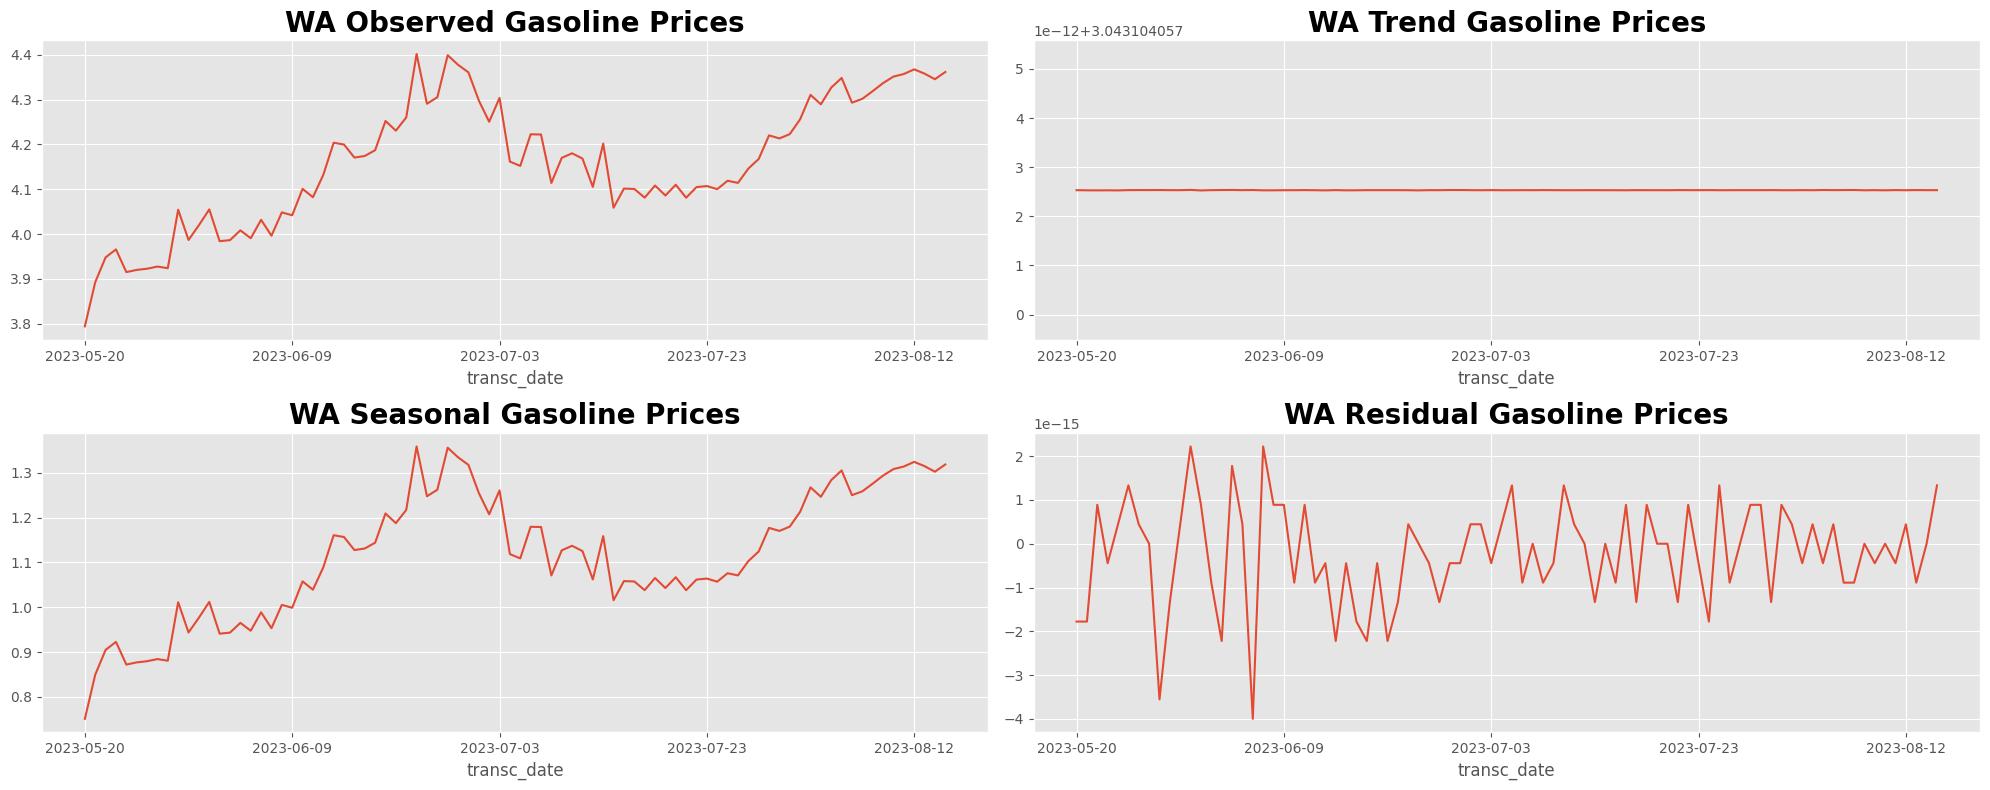

In [114]:
stl: 'STL' = STL(gasprices_df.query("state == 'WA' ").groupby('transc_date')['price'].mean(), period=365).fit() 
fig = plt.figure(figsize=(20,8)) 
ax = fig.add_subplot(2,2,1)
stl.observed.plot(ax=ax) 
ax.set_title("WA Observed Gasoline Prices", fontweight='bold', fontsize=20) 

ax = fig.add_subplot(2,2,2)
stl.trend.plot(ax=ax) 
ax.set_title("WA Trend Gasoline Prices", fontweight='bold', fontsize=20) 

ax = fig.add_subplot(2,2,3)
stl.seasonal.plot(ax=ax) 
ax.set_title("WA Seasonal Gasoline Prices", fontweight='bold', fontsize=20) 

ax = fig.add_subplot(2,2,4)
stl.resid.plot(ax=ax) 
ax.set_title("WA Residual Gasoline Prices", fontweight='bold', fontsize=20) 

plt.tight_layout() 

## **Autocorrelation and Partial Autocorrelation Plot** 
**Note**: the decaying acf plot shows that there is a partial autocorrelation function

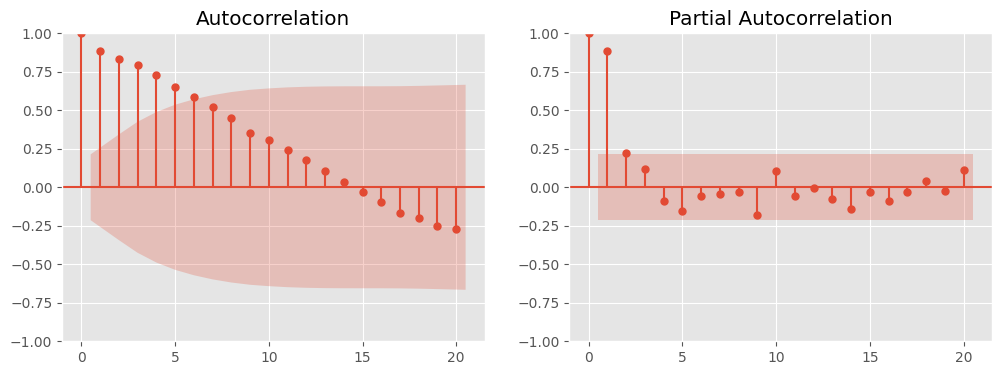

In [17]:
daily_price: 'Series' = wa_prices_df.groupby('transc_date')['price'].mean()
daily_price.index = pd.to_datetime(daily_price.index)

# the decaying acf functions shows that there is a partial autocorrelation
fig = plt.figure(figsize=(12,4)) 
ax = fig.add_subplot(1,2,1)
acf = plot_acf(daily_price, ax=ax)

ax = fig.add_subplot(1,2,2)
pacf = plot_pacf(daily_price, ax=ax) # AR(1)

## **Adfuller Test**
    - Integration Order: 1 
    - Seasonal Integration Order: 0

In [123]:
adf_one: 'adfuller' = adfuller(daily_price) 
pd.DataFrame( {'ADF':adf_one[0], 
               'P-Value': adf_one[1]}, 
             index=['ADF Test']).transpose() 

,ADF Test
ADF,-1.482823
P-Value,0.541991


In [128]:
adf_two: 'adfuler' = adfuller(np.diff(daily_price, n=1))

pd.DataFrame( {'ADF':adf_two[0], 
               'P-Value': adf_two[1]}, 
             index=['ADF Test']).transpose() 

,ADF Test
ADF,-3.756059
P-Value,0.003390


In [41]:
logging.basicConfig(level=logging.INFO)
log: 'LOG' = logging.getLogger(__name__) 
log.setLevel(logging.DEBUG) 

mem_steps: str = f"{path}/pickles/compute_job.pkl"
train: 'Series' = daily_price.sort_index().iloc[:-14]
test: 'Series' = daily_price.sort_index().iloc[-14:]

d: int = 1 
D: int = 0 
s: int = 365 
orders: List[tuple] = list(product(range(3),range(3),range(3),range(3)))
results: defaultdict = defaultdict(list)


for p,q,P,Q in orders: 
    
    if os.path.exists(mem_steps):
        current_job: 'DataFrame' = pd.read_pickle(mem_steps) 
        if (True in current_job.apply(lambda row: True if row['p'] == p and row['q'] == q  and row['P'] == P  and row['Q'] == Q else False, axis=1).tolist()):
            continue 
        
    model: SARIMAX = ARIMA(endog=train, 
                            order=(p,d,q),
                            seasonal_order=(P,D,Q,s), 
                            # enforce_stationarity=False
                            ).fit( cov_type='none', low_memory=True) 
                            #method='cg') # SARIMAX

    results['p'].append(p)
    results['q'].append(q)
    results['P'].append(P)
    results['Q'].append(Q)
    results['AIC'].append(model.aic)
    log.debug("[ + ] (%s,%s,%s,%s) AIC:%s" % (p,q,P,Q,model.aic ) )
    
    if os.path.exists(mem_steps):
        temp: List[Dict] = pd.DataFrame(results).to_dict(orient='records') 
        temp.extend(pd.read_pickle(mem_steps).to_dict(orient='records'))
        pd.DataFrame(temp).drop_duplicates(['p', 'q', 'P', 'Q', 'AIC'] ).to_pickle(mem_steps)

    else: 
        current_job = pd.DataFrame(results) 
        current_job.to_pickle(mem_steps)

In [44]:
pd.read_pickle(mem_steps).sort_values(by='AIC').head(25) 

,p,q,P,Q,AIC
0,0,0,0,2,-199.297378
1,0,0,1,0,-201.297379
2,0,0,1,1,-199.297378
3,0,0,1,2,-197.297378
4,0,0,2,0,-199.297379
5,0,0,2,1,-197.297378
6,0,0,2,2,-195.297378
7,0,1,0,0,-209.339313
8,0,1,0,1,-207.339313
9,0,1,0,2,-205.339313
